Volume Fraction: 0.62
0.001
0.002
0.005
0.01
0.018
0.032
0.056
0.1
0.2
0.3
0.5
1.0
10.0
Exponent = 0.943


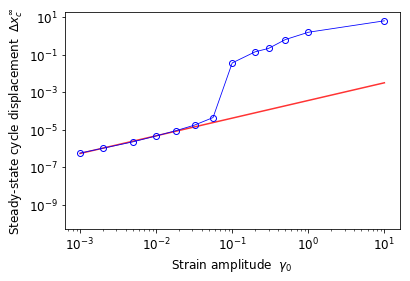

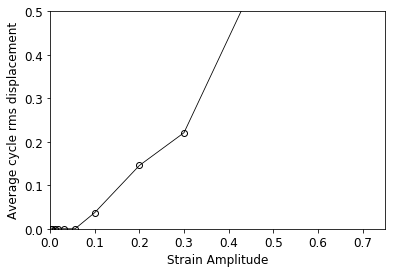

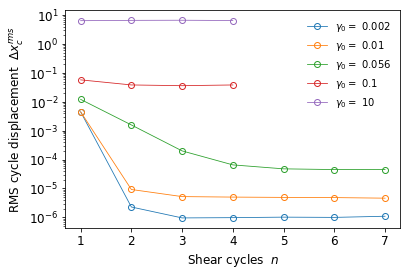

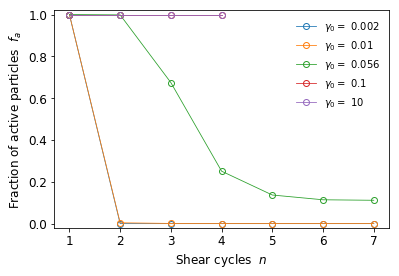

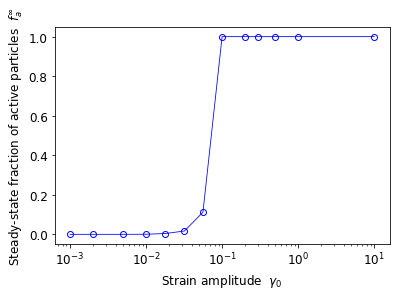

Volume Fraction: 0.68
0.0001
0
0
0.0002
0.0003
0.0005
0.0007
0.001
0.002
0.005
0.01
0.032
0.1
0.2
0.3
0.5
1.0
10.0
Exponent = 1.069


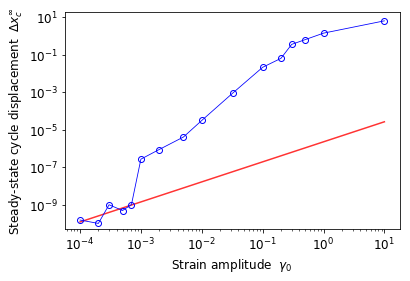

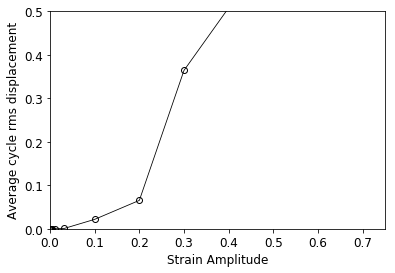

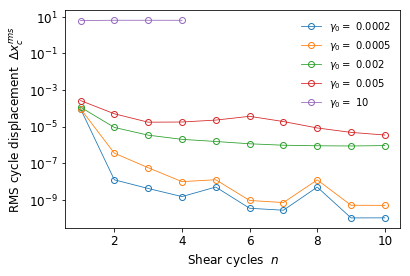

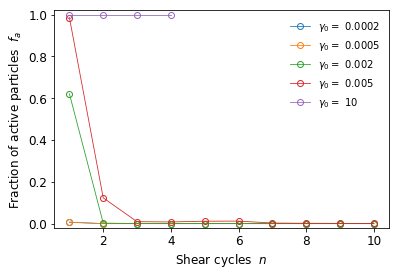

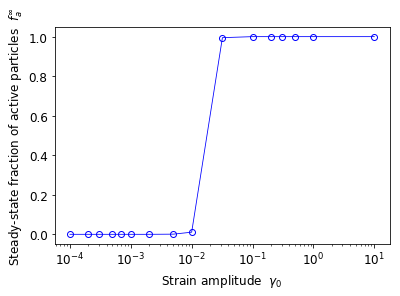

Completed...
Time: 33.797997 s


In [15]:
### this code plots rdf and radial profiles for displacement/contacts from text files produced by contacts_new.py ###

import matplotlib.pyplot as plt
import time
import numpy as np
from scipy import stats
from os import listdir
import re
from operator import itemgetter
from scipy.optimize import curve_fit
start = time.time()
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


# function to calculate radial distribution function and contacts/displacement radial profile
def calc_cycle_displacement(n, x, y, z, box_dim, box_shear, active_dis):
    rms = np.zeros(len(x) - 1)
    active = np.zeros(len(rms))
    error_i = np.zeros(len(rms))
    r_2 = np.zeros([len(rms), n])
    for c in range(len(rms)):
        active_particles = 0
        for i in range(n):
            # distance from particle position at start of cycle to position at start of next cycle
            dx = (x[c+1][i] - x[c][i]) - np.around((x[c+1][i] - x[c][i]) / box_dim[0]) * box_dim[0]
            dy = (y[c+1][i] - y[c][i]) - np.around((y[c+1][i] - y[c][i]) / box_dim[1]) * box_dim[1]
            dz = (z[c+1][i] - z[c][i]) - np.around((z[c+1][i] - z[c][i]) / box_dim[2]) * box_dim[2]
            # correct for shear along xz
            dx -= np.around((z[c+1][i] - z[c][i]) / box_dim[2]) * box_shear[1]
            # total distance squared between particles at end/beginning of cycle
            r_2[c][i] = dx ** 2 + dy ** 2 + dz ** 2
            
            if np.sqrt(r_2[c][i]) > active_dis:
                active_particles += 1
        active[c] = active_particles / n
        
        rms_i = np.sqrt(np.mean(r_2[c]))
        if rms_i > 0.0:
            rms[c] = rms_i
        else:
            rms[c] = 1e-7  # smallest change in displacement that could be calculated
            print(0)
        error_2_i = np.std(r_2[c]) / np.sqrt(len(r_2[c]))  # error in MSD for individual cycle
        error_i[c] = 0.5 / rms[c] * error_2_i  # error in RMSD for individual cycle
    #error = np.sqrt(np.sum(error_i ** 2)) / len(error_i)
    #error = error_i[-1]
    error = np.std(rms[-3:]) / np.sqrt(len(rms[-3:]))
    
    
    return rms, error, active


def tryfloat(s):
    try:
        return float(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[14:-5]
    amp = float(amp)
    #breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return amp

def alphanum_key_large(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[20:-5]
    amp = float(amp)
    #breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return amp


def func(x, a, b, c, d, e):
   return a*np.exp(-b*x)+c*np.exp(-d*x)+e

def fit_curve(x, y, guess):
    xx = np.linspace(x[3], x[-3], 1000)
    popt, pcov = curve_fit(func, x[3:-3], y[3:-3], guess)
    #errors = np.sqrt(np.diag(pcov))
    yy = func(xx, *popt)
    return xx, yy, popt


def find_inflexion(x, y):
    grad = np.gradient(x, y)
    curv = np.gradient(x, grad)
    return np.argmin(curv)


def get_vol_fracs(path):
    all_folders = listdir(path)
    vol_fracs = []
    for folder in all_folders:
        if 'volume_fraction_' in folder:
            vol_fracs.append(float(folder[-5:]))
    return vol_fracs

def calc_micro_reversibility(vol_frac, largesize, supersize):
    data_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data/volume_fraction_%.3f' % vol_frac
    fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/cycle_displacement'
    all_files = listdir(data_path)
    files = []
    for file in all_files:
        if ".dump" in file and "large" not in file and "super" not in file and "repeat" not in file:
            files.append(file)

# large number of particles simulations
    if largesize == True:
        print('Large Sims Volume Fraction: %g' % vol_frac)
        large_files = []
        for file in all_files:
            if ".dump" in file and 'large' in file:
                large_files.append(file)
                
        large_files.sort(key=alphanum_key_large)
        large_shear_amps = np.zeros(len(large_files))
        
        for i in range(len(large_files)):
            large_shear_amps[i] = (float(large_files[i][20:-5]))
            
        large_avg_cycle_rmsd = np.zeros(len(large_shear_amps)) # radial distance from given particle
        large_errors = np.zeros(len(large_shear_amps))
        large_active_frac = []
        large_cycle_rmsd = []
        
        
        for a in range(len(large_shear_amps)):
            shear_amp = large_shear_amps[a]
            large_file = large_files[a]
            print(shear_amp)
            #shear_amp /= round((1250 * (4 /3) * np.pi * (0.7 ** 3 + 0.5 ** 3) / vol_frac) ** (1 / 3) * 1000) / 1000
            file = large_files[a]
            timesteps = []
            all_x = []
            all_y = []
            all_z = []
    
        # reads the datafile and stores relevant data in arrays
            with open('%s/%s' % (data_path, large_file)) as f:
                raw = f.readlines()
                f.close()
            raw = ([x.strip() for x in raw])
            nt = raw.count('ITEM: TIMESTEP')  # number of entries in data file (timesteps)
            n = int(raw[3].split()[0])  # number of particles
    
            for t in range(nt):
                x = []; y = []; z = []
                box_bounds = []
                data = []
                for i in range(n+9):
                    index = i + t * (n + 9)
        # reads the timestep
                    if i == 1:
                        timestep = int(raw[index])
                        timesteps.append(timestep)
        
        # reads box boundaries
                    if 5 <= i < 8:
                        box_bounds.append(list(map(float, raw[index].split())))

        # discards first nine lines and split each line into a list of floats
                    if i > 8:
                        data.append(list(map(float, raw[index].split())))
        # sort data by particle ID
                sorted_data = sorted(data, key=itemgetter(0))
            
                for k in range(len(sorted_data)):
                    x.append(sorted_data[k][1])
                    y.append(sorted_data[k][2])
                    z.append(sorted_data[k][3])
            
                box_bounds = np.array(box_bounds)
                #print('box_bounds:', box_bounds)
                # box shear [xy xz yz]
                box_shear = box_bounds[:, -1]
                # box dimensions [lx ly lz]
                xlo = box_bounds[0][0] - min(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
                xhi = box_bounds[0][1] - max(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
                ylo = box_bounds[1][0] - min(0.0, box_shear[2])
                yhi = box_bounds[1][1] - max(0.0, box_shear[2])
                zlo = box_bounds[2][0]
                zhi = box_bounds[2][1]
                box_dim = np.array([xhi - xlo, yhi - ylo, zhi - zlo])
        
                #print('box dimensions:', box_dim)
                #print('box shear:', box_shear, '\n')

                all_x.append(x)
                all_y.append(y)
                all_z.append(z)
        
            all_x = np.array(all_x)
            all_y = np.array(all_y)
            all_z = np.array(all_z)
    
    
        #cycle_indices = int((period / timestep_length) / (timesteps[-1] - timesteps[-2]))
            rmsd, error, active = calc_cycle_displacement(n, all_x, all_y, all_z, box_dim, box_shear, active_dis)
            print(rmsd)
            large_avg_cycle_rmsd[a] = np.mean(rmsd[-3:])
            large_cycle_rmsd.append(rmsd)
            large_errors[a] = error
            large_active_frac.append(active)
     
    
            
# Super number of particles simulations
    if supersize == True:
        print('Super Sims Volume Fraction: %g' % vol_frac)
        super_files = []
        for file in all_files:
            if ".dump" in file and 'super' in file:
                super_files.append(file)
                
        super_files.sort(key=alphanum_key_large)
        super_shear_amps = np.zeros(len(super_files))
        
        for i in range(len(super_files)):
            super_shear_amps[i] = (float(super_files[i][20:-5]))
            
        super_avg_cycle_rmsd = np.zeros(len(super_shear_amps)) # radial distance from given particle
        super_errors = np.zeros(len(super_shear_amps))
        super_active_frac = []
        super_cycle_rmsd = []
        
        
        for a in range(len(super_shear_amps)):
            shear_amp = super_shear_amps[a]
            super_file = super_files[a]
            print(shear_amp)
            #shear_amp /= round((1250 * (4 /3) * np.pi * (0.7 ** 3 + 0.5 ** 3) / vol_frac) ** (1 / 3) * 1000) / 1000
            file = super_files[a]
            timesteps = []
            all_x = []
            all_y = []
            all_z = []
    
        # reads the datafile and stores relevant data in arrays
            with open('%s/%s' % (data_path, super_file)) as f:
                raw = f.readlines()
                f.close()
            raw = ([x.strip() for x in raw])
            nt = raw.count('ITEM: TIMESTEP')  # number of entries in data file (timesteps)
            n = int(raw[3].split()[0])  # number of particles
    
            for t in range(nt):
                x = []; y = []; z = []
                box_bounds = []
                data = []
                for i in range(n+9):
                    index = i + t * (n + 9)
        # reads the timestep
                    if i == 1:
                        timestep = int(raw[index])
                        timesteps.append(timestep)
        
        # reads box boundaries
                    if 5 <= i < 8:
                        box_bounds.append(list(map(float, raw[index].split())))

        # discards first nine lines and split each line into a list of floats
                    if i > 8:
                        data.append(list(map(float, raw[index].split())))
        # sort data by particle ID
                sorted_data = sorted(data, key=itemgetter(0))
            
                for k in range(len(sorted_data)):
                    x.append(sorted_data[k][1])
                    y.append(sorted_data[k][2])
                    z.append(sorted_data[k][3])
            
                box_bounds = np.array(box_bounds)
                #print('box_bounds:', box_bounds)
                # box shear [xy xz yz]
                box_shear = box_bounds[:, -1]
                # box dimensions [lx ly lz]
                xlo = box_bounds[0][0] - min(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
                xhi = box_bounds[0][1] - max(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
                ylo = box_bounds[1][0] - min(0.0, box_shear[2])
                yhi = box_bounds[1][1] - max(0.0, box_shear[2])
                zlo = box_bounds[2][0]
                zhi = box_bounds[2][1]
                box_dim = np.array([xhi - xlo, yhi - ylo, zhi - zlo])
        
                #print('box dimensions:', box_dim)
                #print('box shear:', box_shear, '\n')

                all_x.append(x)
                all_y.append(y)
                all_z.append(z)
        
            all_x = np.array(all_x)
            all_y = np.array(all_y)
            all_z = np.array(all_z)
    
    
        #cycle_indices = int((period / timestep_length) / (timesteps[-1] - timesteps[-2]))
            rmsd, error, active = calc_cycle_displacement(n, all_x, all_y, all_z, box_dim, box_shear, active_dis)
            print(rmsd)
            super_avg_cycle_rmsd[a] = np.mean(rmsd[-3:])
            super_cycle_rmsd.append(rmsd)
            super_errors[a] = error
            super_active_frac.append(active)
        

# regular simulations
    print('Volume Fraction: %g' % vol_frac)
    files.sort(key=alphanum_key)
    shear_amps = np.zeros(len(files))
    
    for i in range(len(files)):
            shear_amps[i] = (float(files[i][14:-5]))
        
    avg_cycle_rmsd = np.zeros(len(shear_amps)) # radial distance from given particle
    errors = np.zeros(len(shear_amps))
    active_frac = []
    cycle_rmsd = []
    
    for a in range(len(shear_amps)):
        shear_amp = shear_amps[a]
        print(shear_amp)
        #shear_amp /= round((1250 * (4 /3) * np.pi * (0.7 ** 3 + 0.5 ** 3) / vol_frac) ** (1 / 3) * 1000) / 1000
        file = files[a]
        timesteps = []
        all_x = []
        all_y = []
        all_z = []
    
        # reads the datafile and stores relevant data in arrays
        with open('%s/%s' % (data_path, file)) as f:
            raw = f.readlines()
            f.close()
        raw = ([x.strip() for x in raw])
        nt = raw.count('ITEM: TIMESTEP')  # number of entries in data file (timesteps)
        n = int(raw[3].split()[0])  # number of particles
    
        for t in range(nt):
            x = []; y = []; z = []
            box_bounds = []
            data = []
            for i in range(n+9):
                index = i + t * (n + 9)
        # reads the timestep
                if i == 1:
                    timestep = int(raw[index])
                    timesteps.append(timestep)
        
        # reads box boundaries
                if 5 <= i < 8:
                    box_bounds.append(list(map(float, raw[index].split())))

        # discards first nine lines and split each line into a list of floats
                if i > 8:
                    data.append(list(map(float, raw[index].split())))
        # sort data by particle ID
            sorted_data = sorted(data, key=itemgetter(0))
            
            for k in range(len(sorted_data)):
                x.append(sorted_data[k][1])
                y.append(sorted_data[k][2])
                z.append(sorted_data[k][3])
            
            box_bounds = np.array(box_bounds)
            #print('box_bounds:', box_bounds)
            # box shear [xy xz yz]
            box_shear = box_bounds[:, -1]
            # box dimensions [lx ly lz]
            xlo = box_bounds[0][0] - min(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
            xhi = box_bounds[0][1] - max(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
            ylo = box_bounds[1][0] - min(0.0, box_shear[2])
            yhi = box_bounds[1][1] - max(0.0, box_shear[2])
            zlo = box_bounds[2][0]
            zhi = box_bounds[2][1]
            box_dim = np.array([xhi - xlo, yhi - ylo, zhi - zlo])
        
            #print('box dimensions:', box_dim)
            #print('box shear:', box_shear, '\n')

            all_x.append(x)
            all_y.append(y)
            all_z.append(z)
        
        all_x = np.array(all_x)
        all_y = np.array(all_y)
        all_z = np.array(all_z)
    
    
        #cycle_indices = int((period / timestep_length) / (timesteps[-1] - timesteps[-2]))
        rmsd, error, active = calc_cycle_displacement(n, all_x, all_y, all_z, box_dim, box_shear, active_dis)
        avg_cycle_rmsd[a] = np.mean(rmsd[-2:])
        #avg_cycle_rmsd[a] = rmsd[-1]
        cycle_rmsd.append(rmsd)
        errors[a] = error
        active_frac.append(active)
    
        '''plt.figure()
        plt.hist(cycle_displacements, 1000, range=(0.0, 0.2))
        plt.xlabel('Cycle Displacement')
        plt.ylabel('Frequency')
        plt.title('Cycle Displacements for Shear Amplitude: %.3f' % shear_amp)
        plt.show()
        print('Shear Amplitude: %.3f, Time: %f s' % (shear_amp, time.time()-start))'''
      
    '''x = np.log(shear_amps)
    y = np.log(avg_rms_cycle_displacement)
    guess = (10.0, 10.0, -10.0, -10.0, -1.0)
    xx, yy, popt = fit_curve(shear_amps, avg_rms_cycle_displacement, guess)
    print(popt)'''

    '''coeff = np.polyfit(x[1:-1], y[1:-1], 6)
    xx = np.linspace(x[2], x[-2], 1000)
    yy = coeff[-1] + coeff[-2] * xx + coeff[-3] * xx**2 + coeff[-4] * xx**3 + coeff[-5] * xx**4 + coeff[-6] * xx**5 + coeff[-7] * xx**6
    inflexion_index = find_inflexion(xx, yy)
    inflexion_point = xx[inflexion_index]
    print(np.exp(inflexion_point))'''

    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(1e-2, 1e2)
    #plt.xlim(1e-1, 1e1)
    x = np.log(shear_amps)
    y = np.log(avg_cycle_rmsd)
    if vol_frac == 0.66:
        lim = 3
    else:
        lim = 5
    slope, intercept = np.polyfit(x[:lim], y[:lim], 1)
    print('Exponent = %.3f' % slope)
    xx = np.linspace(x[0], x[-1], 1000)
    yy = intercept + slope * xx
    plt.plot(np.exp(xx), np.exp(yy), color='red', alpha=0.8)
    if largesize == True and supersize == False:
        plt.errorbar(shear_amps, avg_cycle_rmsd, yerr=errors, marker='o', color='blue', mfc='none', lw=0.8, capsize=2, label=r'$N=2,500$')
        plt.errorbar(large_shear_amps, large_avg_cycle_rmsd, yerr=large_errors, marker='s', color='green', lw=0.8, capsize=2, label=r'$N=10,000$')
        plt.legend(loc=0)
        plt.legend(frameon=False)
    elif largesize == True and supersize == True:
        plt.plot(shear_amps, avg_cycle_rmsd, marker='o', color='blue', mfc='none', lw=0.8, label=r'$N=2,500$')
        plt.plot(large_shear_amps, large_avg_cycle_rmsd, marker='s', color='green', mfc='none', lw=0.8, label=r'$N=10,000$')
        plt.plot(super_shear_amps, super_avg_cycle_rmsd, marker='^', color='red', mfc='none', lw=0.8, label=r'$N=20,000$')
        plt.legend(loc=0)
        plt.legend(frameon=False)
    else:
        #plt.errorbar(shear_amps, avg_cycle_rmsd, yerr=errors, marker='o', color='blue', mfc='none', lw=0.8, capsize=2)
        plt.plot(shear_amps, avg_cycle_rmsd, marker='o', color='blue', mfc='none', lw=0.8)
    plt.xlabel(r'Strain amplitude  $\gamma_0$')
    plt.ylabel(r'Steady-state cycle displacement  $\Delta x_{c}^{\infty}$')
    plt.ylim(ymin=5e-11, ymax=20)
    #plt.title('Average cycle rms displacement for volume fraction: %.3f' % vol_frac)
    plt.savefig('%s/mean_cycle_displacement_%.3f.png' % (fig_path, vol_frac), dpi=500, bbox_inches='tight')
    
    if largesize == True or supersize == True:
        plt.xlim(0.08)
        plt.ylim(0.01, 20)
        plt.savefig('%s/mean_cycle_displacement_%.3f_zoom.png' % (fig_path, vol_frac), dpi=500, bbox_inches='tight')
    
    plt.figure()
    plt.plot(shear_amps, avg_cycle_rmsd, marker='o', color='black', mfc='none', lw=0.8)
    plt.xlabel('Strain Amplitude')
    plt.ylabel('Average cycle rms displacement')
    #plt.title('Average cycle rms displacement for volume fraction: %.3f' % vol_frac)
    plt.xlim(0, 0.75)
    plt.ylim(0, 0.5)
    plt.show()
    
    
    if len(cycle_rmsd) < 12:
        indices = np.arange(len(cycle_rmsd))
    else:
        indices = np.arange(12)
    indices = [1, 3, 6, 7, -1]
    
    cycle_rmsd = np.array(cycle_rmsd)
    plt.figure()
    for q in indices:
        cycle = np.arange(1, len(cycle_rmsd[q])+1)
        plt.semilogy(cycle, cycle_rmsd[q], marker='o', mfc='none', lw=0.8, label=r'$\gamma_0=$ %g' % shear_amps[q])
    plt.xlabel(r'Shear cycles  $n$')
    plt.ylabel(r'RMS cycle displacement  $\Delta x_c^{rms}$')
    #plt.title('RMSD vs cycles, vol frac: %.3f' % vol_frac)
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.savefig('%s/rmsd_evolution_%.3f.png' % (fig_path, vol_frac), bbox_inches='tight')
    
    active_frac = np.array(active_frac)
    plt.figure()
    for q in indices:
        cycle = np.arange(1, len(cycle_rmsd[q])+1)
        plt.plot(cycle, active_frac[q], marker='o', mfc='none', lw=0.8, label=r'$\gamma_0=$ %g' % shear_amps[q])
    plt.xlabel(r'Shear cycles  $n$')
    plt.ylabel(r'Fraction of active particles  $f_a$')
    #plt.title('Number of active particles as function of number of cycles')
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.ylim(-0.02, 1.02)
    plt.savefig('%s/active_particles_%.3f.png' % (fig_path, vol_frac), dpi=500, bbox_inches='tight')
    plt.show()
    
    plt.figure()
    f_a_infinity = []
    for w in range(len(active_frac)):
        f_a_infinity.append(active_frac[w][-1])
    plt.semilogx(shear_amps, f_a_infinity, marker='o', mfc='none', lw=0.8, color='blue')
    plt.xlabel(r'Strain amplitude  $\gamma_0$')
    plt.ylabel(r'Steady-state fraction of active particles  $f_a^{\infty}$')
    #plt.title('Number of active particles as function of number of cycles')
    plt.savefig('%s/steady_state_active_particles_%.3f.png' % (fig_path, vol_frac), dpi=500, bbox_inches='tight')
    plt.show()
        
        
    return None


        
### code to be executed ###

path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data'
vol_fracs = get_vol_fracs(path)
#vol_fracs = np.array([0.647, 0.648, 0.649, 0.650, 0.660, 0.680, 0.700])
vol_fracs = np.array([0.646, 0.647, 0.648, 0.649, 0.650, 0.660, 0.680, 0.700])
vol_fracs = np.array([0.620, 0.680])
timestep_length = 0.00032149
period = 964.47
active_dis = 5e-5

for vol_frac in vol_fracs:
    if vol_frac == 0.700:
        largesize = True
        supersize = True
    else:
        largesize = False
        supersize = False
    calc_micro_reversibility(vol_frac, largesize, supersize)

    
end = time.time()
print('Completed...')
print('Time: %f s' % (end-start))